In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go

In [2]:
filepath = r"C:\Users\devna\Documents\ML Projects\Computer Vision\Image segmentation\CT_scan.npy"
img = np.load(filepath)

In [3]:
img.shape

(263, 512, 512)

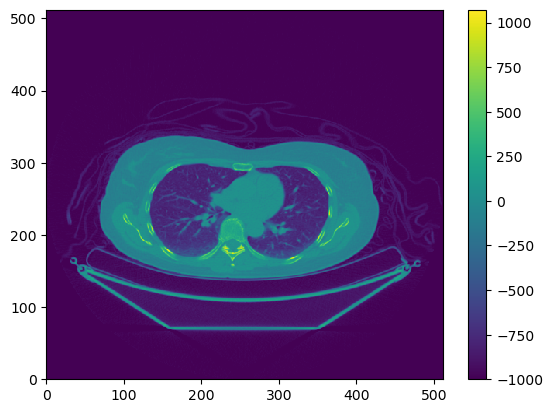

In [11]:
plt.pcolormesh(img[170])
plt.colorbar()

In [15]:
mask= img< -320

# Plot the mask

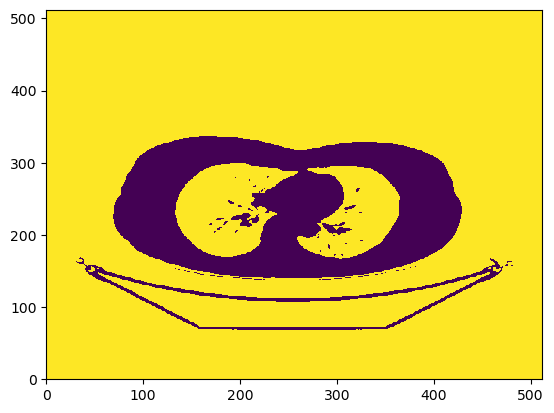

In [16]:
plt.pcolormesh(mask[170])

Next we can use the clear_border funvtion to remove the outer border:


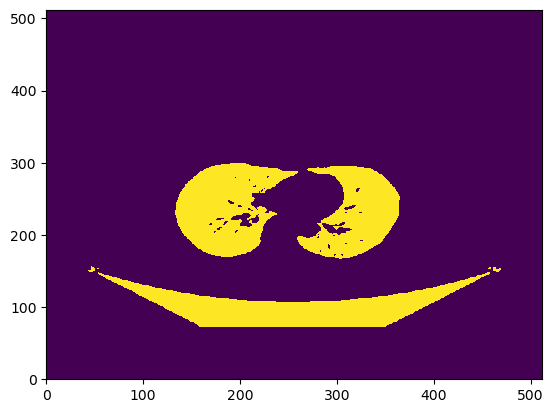

In [19]:
mask = np.vectorize(clear_border, signature='(n,m)->(n,m)')(mask)
plt.pcolormesh(mask[170])

Now we'll give each separate volume a different integer value using the label function

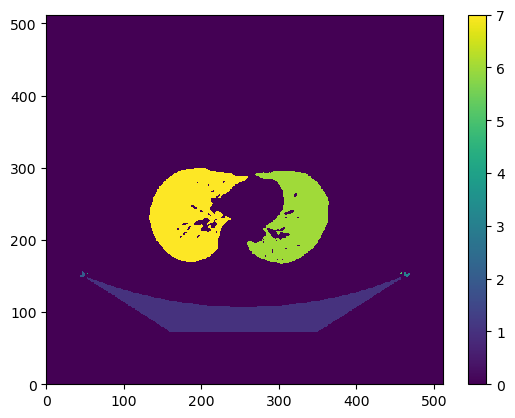

In [23]:
masked_labeled = np.vectorize(label,signature='(n,m)->(n,m)')(mask)
plt.pcolormesh(masked_labeled[170])
plt.colorbar()

Now for something a little non-intuitive. We want to keep the three largest areas for each slice of the image. Why would we want to do this if we only want to keep the two lungs?

* In some slices one of the lungs could be larger than the table
* In some slices one of the lungs could be smaller than the table

If we only take the largest two slices, we might end up taking the table and one of the lungs. So for now lets take the top 3. The function below is designed to operate on a single slice of the 3D image:

In [25]:
slc = masked_labeled[170]
slc.shape

(512, 512)

In [29]:
rps= regionprops(slc)
areas = [r.area for r in rps]
idxs = np.argsort(areas)[:: 1]

In [30]:
np.argsort(areas[::-1])

array([3, 2, 5, 4, 1, 0, 6], dtype=int64)

Only consider the 3 largest areas (iterating through idxs).Add these areas to a new slice called new_slc

In [38]:
new_slc = np.zeros_like(slc)

In [39]:
new_slc = np.zeros_like(slc)
for i in idxs[:3]:
    new_slc[tuple(rps[i].coords.T)] = i+1

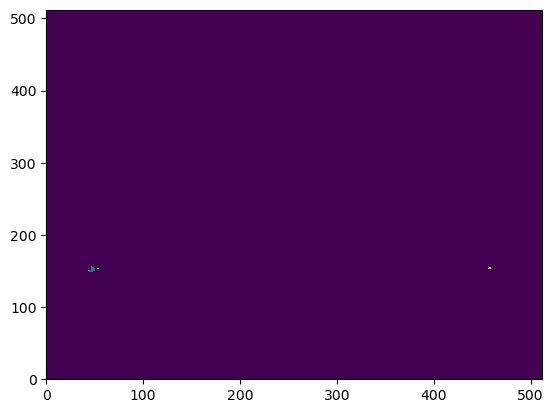

In [40]:
plt.pcolormesh(new_slc)

Now lets automate this for all slices in our 3D image:

In [41]:
def keep_top_3(slc):
    new_slc = np.zeros_like(slc)
    rps = regionprops(slc)
    areas = [r.area for r in rps]
    idxs = np.argsort(areas)[::-1]
    for i in idxs[:3]:
        new_slc[tuple(rps[i].coords.T)] = i+1
    return new_slc

In [44]:
masked_labeled = np.vectorize(keep_top_3, signature='(n,m)->(n,m)')(masked_labeled)

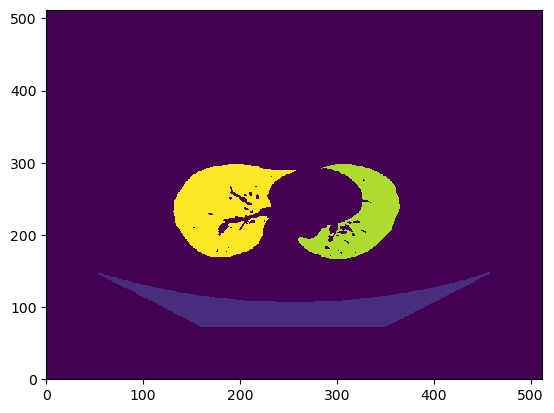

In [46]:
plt.pcolormesh(masked_labeled[165])

Now lets fill in any small holes in the lungs:

In [49]:
mask = masked_labeled > 0
mask = np.vectorize(ndi.binary_fill_holes, signature='(n,m)->(n,m)')(mask)

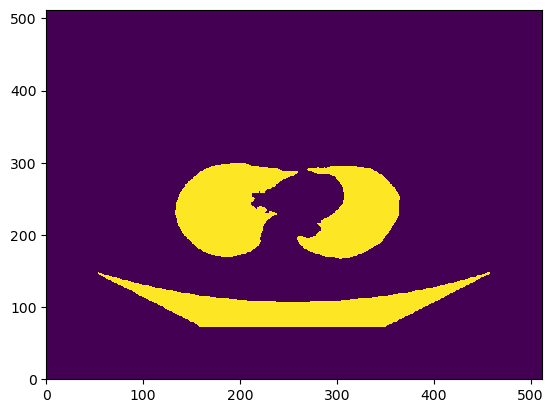

In [50]:
plt.pcolormesh(mask[170])

`In some slices, the trachea is kind of annoying and we need to remove it:

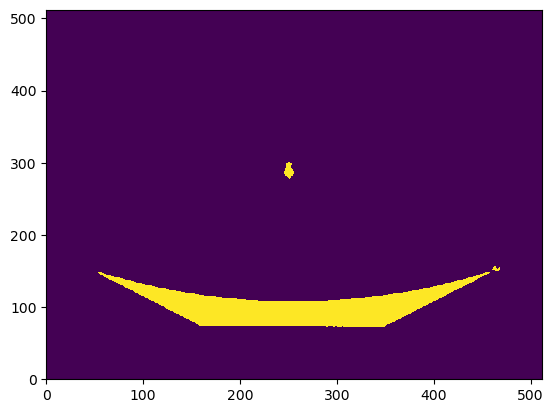

In [51]:
plt.pcolormesh(mask[-50])

In a 512x512 image, the trachea typically takes up less than 0.69% of the area. We can delete all regions that have any area smaller than this percentage:

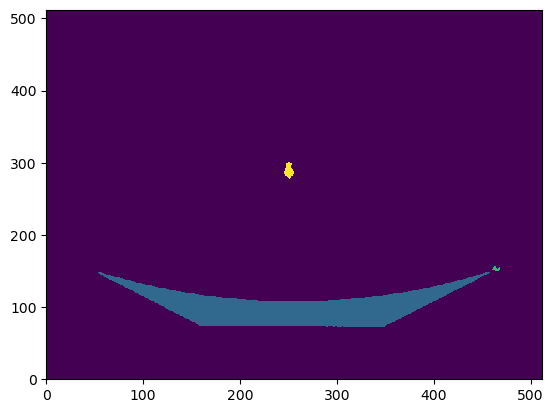

In [52]:
mask[-50]
labels = label(mask[-50],connectivity=1,background=0)
plt.pcolormesh(labels)

In [53]:
rps = regionprops(labels)
areas = np.array([r.area for r in rps])
np.where(areas/512**2 < 0.0069)

(array([1, 2], dtype=int64),)

In [54]:
def remove_trachea(slc, c=0.0069):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1,background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/512**2 < c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc

In [55]:
mask = np.vectorize(remove_trachea, signature='(n,m)->(n,m)')(mask)

Now the trachea is removed in the slice we were considering:

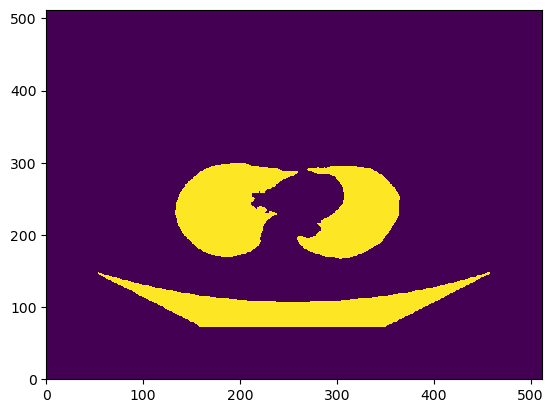

In [56]:
plt.pcolormesh(mask[170])

Finally, its time to remove the table. Note that the center of mass of the table is always lower than the two lungs. As such, we simply need to delete the volume with the lowest center of mass in 
 to delete the table:

In [57]:
labels = label(mask[170], background=0)

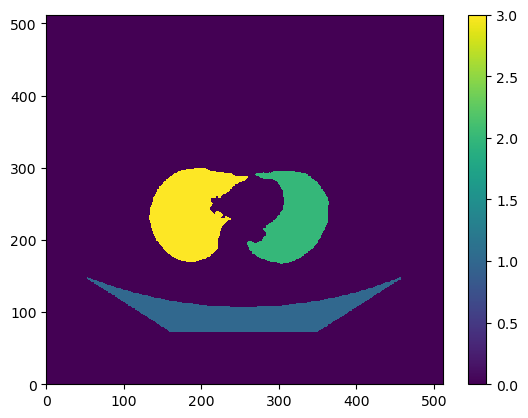

In [58]:
plt.pcolormesh(labels)
plt.colorbar()

Compute the center of masses in this slice:

In [59]:
center_of_mass(labels==3)[0]

237.06954832442935

In [60]:
def delete_table(slc):
    new_slc = slc.copy()
    labels = label(slc, background=0)
    idxs = np.unique(labels)[1:]
    COM_ys = np.array([center_of_mass(labels==i)[0] for i in idxs])
    for idx, COM_y in zip(idxs, COM_ys):
        if (COM_y < 0.3*slc.shape[0]):
            new_slc[labels==idx] = 0
        elif (COM_y > 0.6*slc.shape[0]):
            new_slc[labels==idx] = 0
    return new_slc

In [61]:

mask_new = np.vectorize(delete_table, signature='(n,m)->(n,m)')(mask)

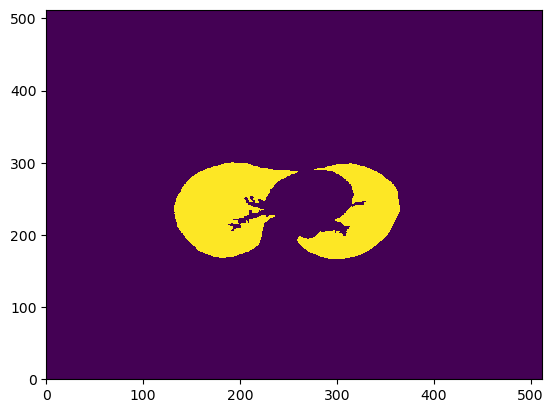

In [62]:
plt.pcolormesh(mask_new[167])

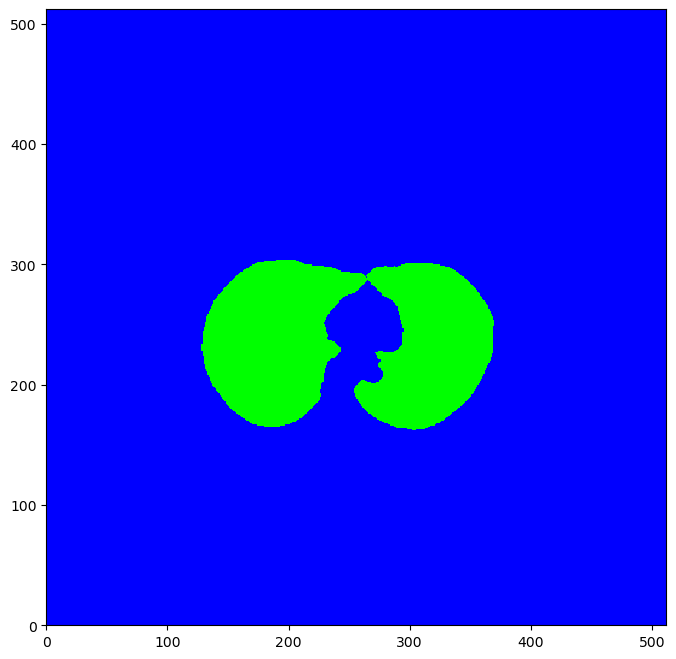

In [63]:
mask_new = binary_dilation(mask_new, iterations=5)
plt.figure(figsize=(8,8))
plt.pcolormesh(mask_new[170], cmap='brg')

Lets plot the full 3D image in plotly and create an interactive plot:

* First decrease the resolution a little bit:

In [64]:

im = zoom(1*(mask_new), (0.4,0.4,0.4))

In [65]:

z, y, x = [np.arange(i) for i in im.shape]
z*=4

In [66]:
X,Y,Z = np.meshgrid(x,y,z, indexing='ij')

# 3D plot

In [67]:
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=np.transpose(im,(1,2,0)).flatten(),
    isomin=0.1,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.write_html("test.html")

In [68]:
img_new = mask_new * img

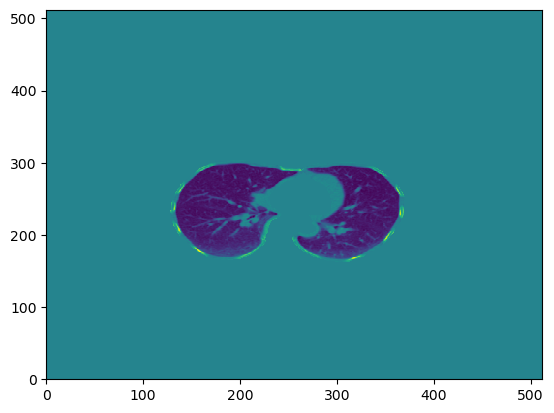

In [69]:
plt.pcolormesh(img_new[170])